In [1]:
# ============================================================================
# NOTEBOOK 5: GAUSSIAN PROCESS SURROGATES FOR DRAKE EQUATION
# ============================================================================
#
# This notebook uses Gaussian Processes (GPs) to:
# 1. Create a fast surrogate model of the Drake Equation
# 2. Perform efficient parameter space exploration
# 3. Quantify uncertainty in predictions
# 4. Enable Bayesian optimization for interesting parameter regions

# ============================================================================
# CELL 1: IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats

from drake.Parameters import BASELINE_PARAMS
from drake.Simulation import simulate_once
from drake.gaussian_process import gp_sample

# For GP modeling
try:
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel
    from sklearn.preprocessing import StandardScaler
    SKLEARN_AVAILABLE = True
except ImportError:
    print("Warning: scikit-learn not available. Install with: pip install scikit-learn")
    SKLEARN_AVAILABLE = False

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

print("✓ Imports successful")

✓ Imports successful


In [3]:
# ============================================================================
# CELL 2: GENERATE TRAINING DATA
# ============================================================================

def generate_training_data(n_samples=100, params=['R_star', 'fp', 'ne']):
    """
    Generate training data for GP surrogate.
    For simplicity, we'll focus on a subset of parameters.
    """
    training_data = []
    
    for _ in range(n_samples):
        result = simulate_once(BASELINE_PARAMS)
        training_data.append(result)
    
    df = pd.DataFrame(training_data)
    return df

# Generate training data
n_train = 200
train_df = generate_training_data(n_train)

print(f"Generated {len(train_df)} training samples")
print(f"\nTraining data summary:")
print(train_df.describe())

Generated 200 training samples

Training data summary:
           R_star          fp          ne          fl          fi          fc  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     1.538909    0.961408    0.224954    0.532914    0.094959    0.227501   
std      0.465432    0.026744    0.122554    0.282934    0.063450    0.117315   
min      0.509855    0.859431    0.066389    0.015677    0.003644    0.023213   
25%      1.224141    0.949184    0.144099    0.276316    0.052533    0.141825   
50%      1.529795    0.966104    0.200033    0.555546    0.084530    0.209599   
75%      1.847779    0.981138    0.280421    0.787821    0.122055    0.292012   
max      2.945340    0.999314    1.079729    0.979641    0.387922    0.614833   

                 L           N  
count   200.000000  200.000000  
mean    209.584693    0.765370  
std     231.735261    1.249511  
min     100.079711    0.001503  
25%     120.081321    0.128798  
50%     148.68969

Training Gaussian Process...
✓ GP trained successfully

Optimized kernel: 2.29**2 * RBF(length_scale=3.72) + WhiteKernel(noise_level=0.000801)
Log marginal likelihood: 78.01

Training Performance:
R² Score: 0.9998
RMSE: 0.0027


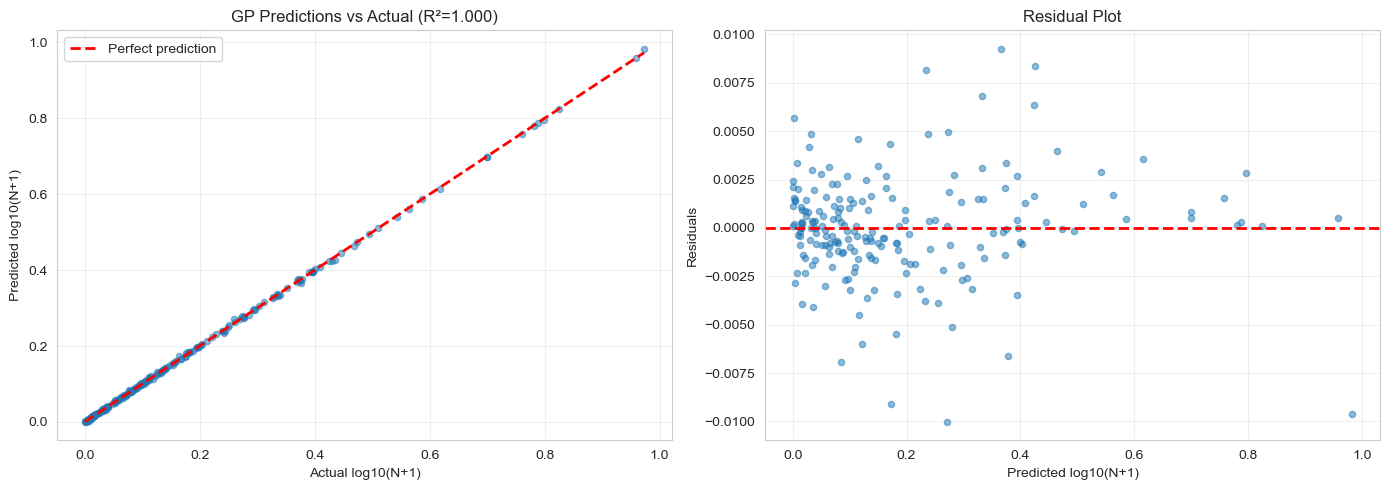

In [5]:
# ============================================================================
# CELL 3: BUILD GP SURROGATE MODEL
# ============================================================================

if SKLEARN_AVAILABLE:
    # Select features (parameters) and target (N)
    feature_cols = ['R_star', 'fp', 'ne', 'fl', 'fi', 'fc', 'L']
    X_train = train_df[feature_cols].values
    y_train = np.log10(train_df['N'].values + 1)  # Log transform for better GP performance
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Define GP kernel
    # Using RBF (squared exponential) kernel with noise
    kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
    
    # Create and train GP
    gp = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=10,
        alpha=1e-6,
        normalize_y=True
    )
    
    print("Training Gaussian Process...")
    gp.fit(X_train_scaled, y_train)
    print("✓ GP trained successfully")
    print(f"\nOptimized kernel: {gp.kernel_}")
    print(f"Log marginal likelihood: {gp.log_marginal_likelihood(gp.kernel_.theta):.2f}")
    
    # Evaluate on training data
    y_pred_train, y_std_train = gp.predict(X_train_scaled, return_std=True)
    
    # Calculate R²
    from sklearn.metrics import r2_score, mean_squared_error
    r2 = r2_score(y_train, y_pred_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    
    print(f"\nTraining Performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    # Plot predictions vs actual
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Predictions vs Actual
    axes[0].scatter(y_train, y_pred_train, alpha=0.5, s=20)
    axes[0].plot([y_train.min(), y_train.max()], 
                 [y_train.min(), y_train.max()], 
                 'r--', linewidth=2, label='Perfect prediction')
    axes[0].set_xlabel('Actual log10(N+1)')
    axes[0].set_ylabel('Predicted log10(N+1)')
    axes[0].set_title(f'GP Predictions vs Actual (R²={r2:.3f})')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Residuals
    residuals = y_train - y_pred_train
    axes[1].scatter(y_pred_train, residuals, alpha=0.5, s=20)
    axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Predicted log10(N+1)')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title('Residual Plot')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("sklearn not available. Install with: pip install scikit-learn")

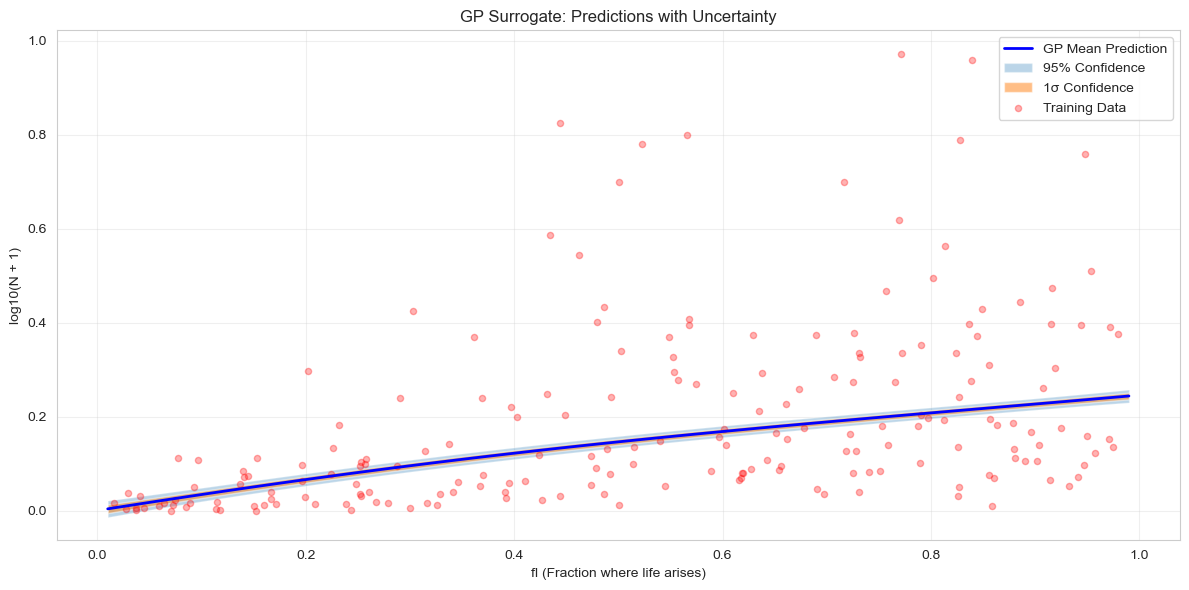

In [7]:
# ============================================================================
# CELL 4: VISUALIZE GP PREDICTIONS WITH UNCERTAINTY
# ============================================================================

if SKLEARN_AVAILABLE:
    # Vary fl while keeping others at median
    fl_range = np.linspace(0.01, 0.99, 100)
    X_test = np.zeros((len(fl_range), len(feature_cols)))
    
    # Set to median values
    for i, col in enumerate(feature_cols):
        X_test[:, i] = train_df[col].median()
    
    # Vary fl (index 3)
    X_test[:, 3] = fl_range
    
    # Scale and predict
    X_test_scaled = scaler.transform(X_test)
    y_pred, y_std = gp.predict(X_test_scaled, return_std=True)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(fl_range, y_pred, 'b-', linewidth=2, label='GP Mean Prediction')
    plt.fill_between(fl_range, 
                     y_pred - 1.96 * y_std, 
                     y_pred + 1.96 * y_std,
                     alpha=0.3, label='95% Confidence')
    plt.fill_between(fl_range, 
                     y_pred - y_std, 
                     y_pred + y_std,
                     alpha=0.5, label='1σ Confidence')
    
    # Add training points
    train_fl = train_df['fl'].values
    train_N = np.log10(train_df['N'].values + 1)
    plt.scatter(train_fl, train_N, c='red', s=20, alpha=0.3, label='Training Data')
    
    plt.xlabel('fl (Fraction where life arises)')
    plt.ylabel('log10(N + 1)')
    plt.title('GP Surrogate: Predictions with Uncertainty')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("sklearn not available.")

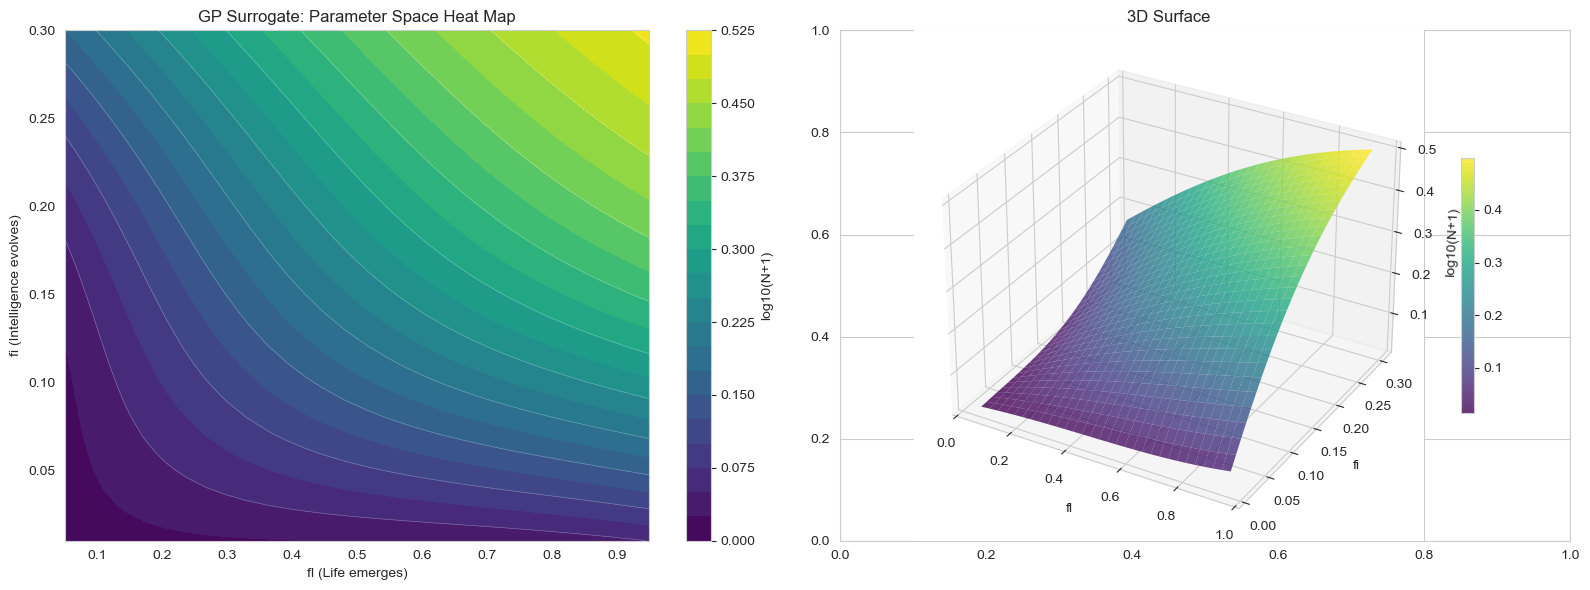

In [9]:
# ============================================================================
# CELL 5: 2D PARAMETER SPACE EXPLORATION
# ============================================================================

if SKLEARN_AVAILABLE:
    # Create 2D grid: fl vs fi
    fl_grid = np.linspace(0.05, 0.95, 30)
    fi_grid = np.linspace(0.01, 0.3, 30)
    FL, FI = np.meshgrid(fl_grid, fi_grid)
    
    # Prepare test points
    n_points = len(fl_grid) * len(fi_grid)
    X_test_2d = np.zeros((n_points, len(feature_cols)))
    
    # Set to median values
    for i, col in enumerate(feature_cols):
        X_test_2d[:, i] = train_df[col].median()
    
    # Vary fl and fi
    X_test_2d[:, 3] = FL.ravel()  # fl
    X_test_2d[:, 4] = FI.ravel()  # fi
    
    # Predict
    X_test_2d_scaled = scaler.transform(X_test_2d)
    Z_pred = gp.predict(X_test_2d_scaled)
    Z = Z_pred.reshape(FL.shape)
    
    # Plot 2D heatmap
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Contour plot
    contour = axes[0].contourf(FL, FI, Z, levels=20, cmap='viridis')
    axes[0].contour(FL, FI, Z, levels=10, colors='white', alpha=0.3, linewidths=0.5)
    plt.colorbar(contour, ax=axes[0], label='log10(N+1)')
    axes[0].set_xlabel('fl (Life emerges)')
    axes[0].set_ylabel('fi (Intelligence evolves)')
    axes[0].set_title('GP Surrogate: Parameter Space Heat Map')
    
    # 3D surface
    ax3d = fig.add_subplot(122, projection='3d')
    surf = ax3d.plot_surface(FL, FI, Z, cmap='viridis', alpha=0.8, 
                             linewidth=0, antialiased=True)
    ax3d.set_xlabel('fl')
    ax3d.set_ylabel('fi')
    ax3d.set_zlabel('log10(N+1)')
    ax3d.set_title('3D Surface')
    plt.colorbar(surf, ax=ax3d, shrink=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print("sklearn not available.")

In [11]:
# ============================================================================
# CELL 6: ACQUISITION FUNCTION FOR BAYESIAN OPTIMIZATION
# ============================================================================

if SKLEARN_AVAILABLE:
    def expected_improvement(X, gp, y_max, xi=0.01):
        """
        Calculate Expected Improvement acquisition function.
        
        X: points to evaluate
        gp: trained GP model
        y_max: current maximum observed value
        xi: exploration parameter
        """
        mu, sigma = gp.predict(X, return_std=True)
        sigma = sigma.reshape(-1, 1)
        
        with np.errstate(divide='warn'):
            imp = mu - y_max - xi
            Z = imp / sigma
            ei = imp * stats.norm.cdf(Z) + sigma * stats.norm.pdf(Z)
            ei[sigma == 0.0] = 0.0
        
        return ei
    
    # Calculate acquisition function over 1D slice
    y_max = y_train.max()
    
    fl_range = np.linspace(0.01, 0.99, 100)
    X_test = np.zeros((len(fl_range), len(feature_cols)))
    for i, col in enumerate(feature_cols):
        X_test[:, i] = train_df[col].median()
    X_test[:, 3] = fl_range
    
    X_test_scaled = scaler.transform(X_test)
    y_pred, y_std = gp.predict(X_test_scaled, return_std=True)
    ei = expected_improvement(X_test_scaled, gp, y_max)
    
    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # GP prediction with uncertainty
    axes[0].plot(fl_range, y_pred, 'b-', linewidth=2, label='Mean Prediction')
    axes[0].fill_between(fl_range, 
                         y_pred - 1.96 * y_std, 
                         y_pred + 1.96 * y_std,
                         alpha=0.3)
    axes[0].axhline(y_max, color='red', linestyle='--', label='Current Max')
    axes[0].set_ylabel('log10(N+1)')
    axes[0].set_title('GP Predictions')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Acquisition function
    axes[1].plot(fl_range, ei, 'g-', linewidth=2)
    axes[1].fill_between(fl_range, 0, ei.ravel(), alpha=0.3, color='green')
    best_idx = np.argmax(ei)
    axes[1].axvline(fl_range[best_idx], color='red', linestyle='--', 
                    label=f'Best acquisition: fl={fl_range[best_idx]:.3f}')
    axes[1].set_xlabel('fl (Fraction where life arises)')
    axes[1].set_ylabel('Expected Improvement')
    axes[1].set_title('Acquisition Function (Expected Improvement)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nBayesian Optimization Suggestion:")
    print("="*50)
    print(f"Next point to sample: fl = {fl_range[best_idx]:.4f}")
    print(f"Expected improvement: {ei.max():.4f}")
else:
    print("sklearn not available.")

IndexError: boolean index did not match indexed array along dimension 1; dimension is 100 but corresponding boolean dimension is 1

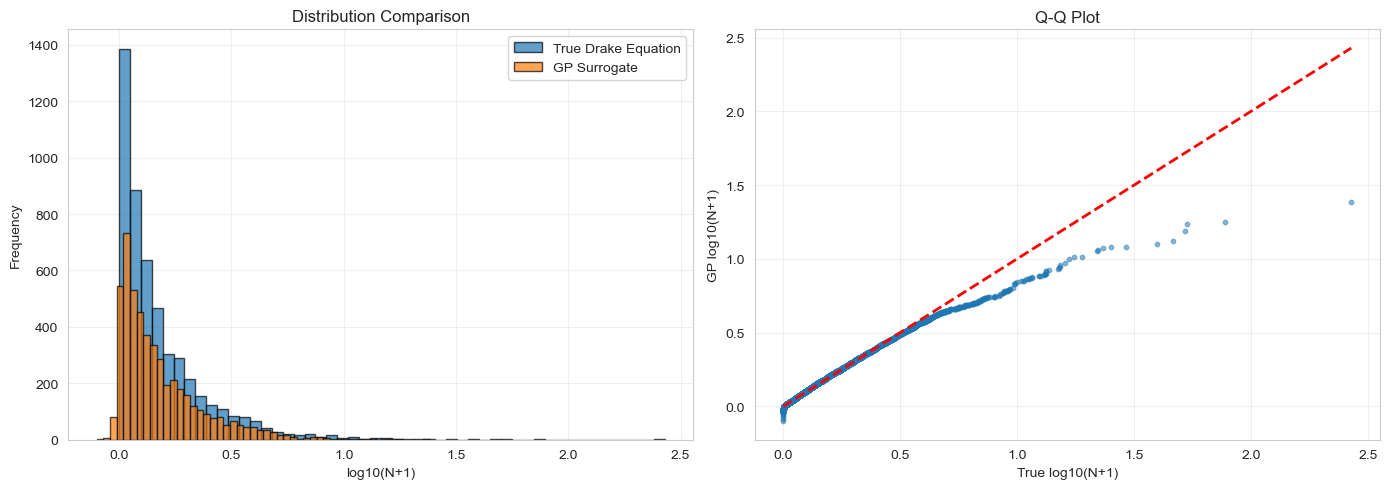


Distribution Comparison:
                        True GP Surrogate      Error
--------------------------------------------------
Mean N:                 1.53         1.51       0.8%
Median N:               1.30         1.32       1.8%
Std Dev:                1.61         1.53       5.1%


In [13]:
# ============================================================================
# CELL 7: GP-BASED MONTE CARLO
# ============================================================================

if SKLEARN_AVAILABLE:
    # Generate test samples
    n_mc = 5000
    test_samples = generate_training_data(n_mc)
    
    X_mc = test_samples[feature_cols].values
    y_true = np.log10(test_samples['N'].values + 1)
    
    # GP predictions
    X_mc_scaled = scaler.transform(X_mc)
    y_gp = gp.predict(X_mc_scaled)
    
    # Compare distributions
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histograms
    axes[0].hist(y_true, bins=50, alpha=0.7, label='True Drake Equation', edgecolor='black')
    axes[0].hist(y_gp, bins=50, alpha=0.7, label='GP Surrogate', edgecolor='black')
    axes[0].set_xlabel('log10(N+1)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Q-Q plot
    axes[1].scatter(np.sort(y_true), np.sort(y_gp), alpha=0.5, s=10)
    axes[1].plot([y_true.min(), y_true.max()], 
                 [y_true.min(), y_true.max()], 
                 'r--', linewidth=2)
    axes[1].set_xlabel('True log10(N+1)')
    axes[1].set_ylabel('GP log10(N+1)')
    axes[1].set_title('Q-Q Plot')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics comparison
    print("\nDistribution Comparison:")
    print("="*50)
    print(f"{'':15} {'True':>12} {'GP Surrogate':>12} {'Error':>10}")
    print("-"*50)
    
    true_mean = 10**y_true.mean()
    gp_mean = 10**y_gp.mean()
    print(f"{'Mean N:':15} {true_mean:>12.2f} {gp_mean:>12.2f} {abs(true_mean-gp_mean)/true_mean*100:>9.1f}%")
    
    true_median = 10**np.median(y_true)
    gp_median = 10**np.median(y_gp)
    print(f"{'Median N:':15} {true_median:>12.2f} {gp_median:>12.2f} {abs(true_median-gp_median)/true_median*100:>9.1f}%")
    
    true_std = 10**y_true.std()
    gp_std = 10**y_gp.std()
    print(f"{'Std Dev:':15} {true_std:>12.2f} {gp_std:>12.2f} {abs(true_std-gp_std)/true_std*100:>9.1f}%")
else:
    print("sklearn not available.")

In [15]:
# ============================================================================
# CELL 8: COMPUTATIONAL SPEEDUP ANALYSIS
# ============================================================================

import time

if SKLEARN_AVAILABLE:
    n_test = 10000
    
    # Time true simulations
    start = time.time()
    for _ in range(n_test):
        _ = simulate_once(BASELINE_PARAMS)
    time_true = time.time() - start
    
    # Time GP predictions
    test_samples = generate_training_data(n_test)
    X_test = test_samples[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    
    start = time.time()
    _ = gp.predict(X_test_scaled)
    time_gp = time.time() - start
    
    speedup = time_true / time_gp
    
    print("\nComputational Performance:")
    print("="*50)
    print(f"True simulation time: {time_true:.4f} seconds")
    print(f"GP prediction time:   {time_gp:.4f} seconds")
    print(f"\nSpeedup factor: {speedup:.2f}x")
    print(f"\nFor {n_test:,} evaluations:")
    print(f"  True: {time_true/n_test*1e6:.2f} μs per evaluation")
    print(f"  GP:   {time_gp/n_test*1e6:.2f} μs per evaluation")
else:
    print("sklearn not available.")


Computational Performance:
True simulation time: 173.9743 seconds
GP prediction time:   0.1997 seconds

Speedup factor: 871.21x

For 10,000 evaluations:
  True: 17397.43 μs per evaluation
  GP:   19.97 μs per evaluation
